In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os



Mounted at /content/drive


In [ ]:
# =============================
# Load Your Datasets (with Fintech/)
# =============================

base = "/content/drive/MyDrive/Fintech/Dataset"

# ---- 1. News Sentiment ----
arkf_news = pd.read_csv(f"{base}/Stock_News/ARKF_companynews_sentiment_202501_202510.csv")
arkk_news = pd.read_csv(f"{base}/Stock_News/ARKK_companynews_sentiment_202501_202510.csv")

# ---- 2. ETF Daily Returns ----
arkf_returns = pd.read_csv(f"{base}/ETF_dailyreturns/price_returns_ARKF.csv")
arkk_returns = pd.read_csv(f"{base}/ETF_dailyreturns/price_returns_ARKK.csv")

# ---- 3. Daily Holdings ----
arkk_hold = pd.read_csv(f"{base}/Holding_data/ARKK_Holdings_2025-01-01_to_2025-10-31.csv")
arkf_hold = pd.read_csv(f"{base}/Holding_data/ARKF_Holdings_2025-01-01_to_2025-10-31.csv")

# ---- 4. Trades ----
arkk_trades = pd.read_csv(f"{base}/Trades_data/arkk_trades_2025-01_to_2025-10.csv")
arkf_trades = pd.read_csv(f"{base}/Trades_data/arkf_trades_2025-01_to_2025-10.csv")




In [ ]:
def aggregate_sentiment(df):
    df['date'] = pd.to_datetime(df['date'])
    return df.groupby('date')['sentiment'].mean().reset_index()

sent_arkk = aggregate_sentiment(arkk_news)
sent_arkf = aggregate_sentiment(arkf_news)

sent_arkk.rename(columns={'sentiment': 'sentiment_arkk'}, inplace=True)
sent_arkf.rename(columns={'sentiment': 'sentiment_arkf'}, inplace=True)

In [ ]:
# Convert date
arkk_returns["Date"] = pd.to_datetime(arkk_returns["Date"])
arkf_returns["Date"] = pd.to_datetime(arkf_returns["Date"])

arkk_returns.rename(columns={'Return_1d': 'return_arkk'}, inplace=True)
arkf_returns.rename(columns={'Return_1d': 'return_arkf'}, inplace=True)

# Merge ARKK
df_arkk = pd.merge(arkk_returns, sent_arkk,
                   left_on='Date', right_on='date', how='left')
df_arkk.drop(columns=['date'], inplace=True)

# Merge ARKF
df_arkf = pd.merge(arkf_returns, sent_arkf,
                   left_on='Date', right_on='date', how='left')
df_arkf.drop(columns=['date'], inplace=True)



### Compute Daily Weight Changes

In [ ]:
def compute_weight_change(df):
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['ticker','date'])
    df['weight_change'] = df.groupby('ticker')['weight'].diff()
    return df

arkk_hold = compute_weight_change(arkk_hold)
arkf_hold = compute_weight_change(arkf_hold)

# Sum daily rotation
arkk_rotation = arkk_hold.groupby('date')['weight_change'].sum().reset_index()
arkk_rotation.rename(columns={'weight_change': 'rotation_arkk'}, inplace=True)

arkf_rotation = arkf_hold.groupby('date')['weight_change'].sum().reset_index()
arkf_rotation.rename(columns={'weight_change': 'rotation_arkf'}, inplace=True)



In [ ]:
# ARKK
df_arkkk = pd.merge(df_arkk, arkk_rotation,
                    left_on='Date', right_on='date', how='left')
df_arkkk.drop(columns=['date'], inplace=True)
df_arkk = df_arkkk.copy()

# ARKF
df_arkff = pd.merge(df_arkf, arkf_rotation,
                    left_on='Date', right_on='date', how='left')
df_arkff.drop(columns=['date'], inplace=True)
df_arkf = df_arkff.copy()



### Detect Trades

In [ ]:
# Convert date
arkk_trades['date'] = pd.to_datetime(arkk_trades['date'])
arkf_trades['date'] = pd.to_datetime(arkf_trades['date'])

arkk_trades['trade_event'] = 1
arkf_trades['trade_event'] = 1

# Merge into main df
df_arkk = pd.merge(df_arkk,
                   arkk_trades[['date','trade_event']],
                   left_on='Date', right_on='date', how='left')
df_arkk['trade_event'] = df_arkk['trade_event'].fillna(0)
df_arkk.drop(columns=['date'], inplace=True)

df_arkf = pd.merge(df_arkf,
                   arkf_trades[['date','trade_event']],
                   left_on='Date', right_on='date', how='left')
df_arkf['trade_event'] = df_arkf['trade_event'].fillna(0)
df_arkf.drop(columns=['date'], inplace=True)


### Correlation Analysis

In [ ]:
save_dir = f"{base}/Panel_data"
os.makedirs(save_dir, exist_ok=True)

df_arkk.to_csv(f"{save_dir}/df_arkk_panel.csv", index=False)
df_arkf.to_csv(f"{save_dir}/df_arkf_panel.csv", index=False)

print("Saved panel dataset to:")
print(f"- {save_dir}/df_arkk_panel.csv")
print(f"- {save_dir}/df_arkf_panel.csv")


Saved panel dataset to:
- /content/drive/MyDrive/Fintech/Dataset/Panel_data/df_arkk_panel.csv
- /content/drive/MyDrive/Fintech/Dataset/Panel_data/df_arkf_panel.csv


In [ ]:
import pandas as pd

# === File paths (modify if needed) ===
arkk_top20_path = "/content/drive/MyDrive/Fintech/Dataset/Holding_data/ARKK_top20_holdings.csv"
arkf_top20_path = "/content/drive/MyDrive/Fintech/Dataset/Holding_data/ARKF_top20_holdings.csv"

# === Load CSV files ===
arkk_top20 = pd.read_csv(arkk_top20_path)
arkf_top20 = pd.read_csv(arkf_top20_path)

print("=== ARKK Top 20 Holdings ===")
display(arkk_top20)

print("=== ARKF Top 20 Holdings ===")
display(arkf_top20)


=== ARKK Top 20 Holdings ===


,ticker,company,weight
0,TSLA,TESLA INC,11.573571
1,ROKU,ROKU INC,7.443333
2,COIN,COINBASE GLOBAL INC -CLASS A,7.413429
3,RBLX,ROBLOX CORP -CLASS A,6.484381
4,PLTR,PALANTIR TECHNOLOGIES INC-A,5.203381
5,CRSP,CRISPR THERAPEUTICS AG,5.006143
6,TEM,TEMPUS AI INC,4.787381
7,SHOP,SHOPIFY INC - CLASS A,4.700667
8,HOOD,ROBINHOOD MARKETS INC - A,4.676619
9,SQ,BLOCK INC,3.879286


=== ARKF Top 20 Holdings ===


,ticker,company,weight
0,SHOP,SHOPIFY INC - CLASS A,9.591053
1,COIN,COINBASE GLOBAL INC -CLASS A,7.827656
2,HOOD,ROBINHOOD MARKETS INC - A,6.885598
3,SQ,BLOCK INC,6.067857
4,CRCL,CIRCLE INTERNET GROUP INC,4.656100
5,TOST,TOAST INC-CLASS A,4.638612
6,RBLX,ROBLOX CORP -CLASS A,4.402153
7,PLTR,PALANTIR TECHNOLOGIES INC-A,4.202249
8,XYZ,BLOCK INC,3.795026
9,SOFI,SOFI TECHNOLOGIES INC,3.441292


## Fintech Mapping

In [ ]:
# ===========================================
# Part 1 — Define FinTech universe + Add is_fintech flag
# ===========================================

# FinTech stock list based on industry + ARKF/ARKK holdings
fintech_list = [
    "COIN", "SQ", "HOOD", "SOFI",
    "TOST", "AFRM", "CRCL", "UPST"
]

print("FinTech universe:", fintech_list)

# Add FinTech indicator (1 = FinTech, 0 = Non-FinTech)
arkk_top20["is_fintech"] = arkk_top20["ticker"].isin(fintech_list).astype(int)
arkf_top20["is_fintech"] = arkf_top20["ticker"].isin(fintech_list).astype(int)

print("=== ARKK Top 20 with FinTech flag ===")
display(arkk_top20)

print("=== ARKF Top 20 with FinTech flag ===")
display(arkf_top20)


FinTech universe: ['COIN', 'SQ', 'HOOD', 'SOFI', 'TOST', 'AFRM', 'CRCL', 'UPST']
=== ARKK Top 20 with FinTech flag ===


,ticker,company,weight,is_fintech
0,TSLA,TESLA INC,11.573571,0
1,ROKU,ROKU INC,7.443333,0
2,COIN,COINBASE GLOBAL INC -CLASS A,7.413429,1
3,RBLX,ROBLOX CORP -CLASS A,6.484381,0
4,PLTR,PALANTIR TECHNOLOGIES INC-A,5.203381,0
5,CRSP,CRISPR THERAPEUTICS AG,5.006143,0
6,TEM,TEMPUS AI INC,4.787381,0
7,SHOP,SHOPIFY INC - CLASS A,4.700667,0
8,HOOD,ROBINHOOD MARKETS INC - A,4.676619,1
9,SQ,BLOCK INC,3.879286,1


=== ARKF Top 20 with FinTech flag ===


,ticker,company,weight,is_fintech
0,SHOP,SHOPIFY INC - CLASS A,9.591053,0
1,COIN,COINBASE GLOBAL INC -CLASS A,7.827656,1
2,HOOD,ROBINHOOD MARKETS INC - A,6.885598,1
3,SQ,BLOCK INC,6.067857,1
4,CRCL,CIRCLE INTERNET GROUP INC,4.656100,1
5,TOST,TOAST INC-CLASS A,4.638612,1
6,RBLX,ROBLOX CORP -CLASS A,4.402153,0
7,PLTR,PALANTIR TECHNOLOGIES INC-A,4.202249,0
8,XYZ,BLOCK INC,3.795026,0
9,SOFI,SOFI TECHNOLOGIES INC,3.441292,1


In [ ]:
# ===========================================
# Part 2 — Combine Top20 holdings + compute weight distribution
# ===========================================

combined_top20 = pd.concat([
    arkk_top20.assign(fund="ARKK"),
    arkf_top20.assign(fund="ARKF")
], ignore_index=True)

print("=== Combined Top 20 Holdings from ARKK + ARKF ===")
display(combined_top20)

# Weight share of FinTech vs Non-FinTech
weight_summary = (
    combined_top20
        .groupby("is_fintech")["weight"]
        .sum()
        .reset_index()
)

weight_summary["group"] = weight_summary["is_fintech"].map({1:"FinTech", 0:"Non-FinTech"})

print("=== Weight Distribution (FinTech vs Non-FinTech) ===")
display(weight_summary)


=== Combined Top 20 Holdings from ARKK + ARKF ===


,ticker,company,weight,is_fintech,fund
0,TSLA,TESLA INC,11.573571,0,ARKK
1,ROKU,ROKU INC,7.443333,0,ARKK
2,COIN,COINBASE GLOBAL INC -CLASS A,7.413429,1,ARKK
3,RBLX,ROBLOX CORP -CLASS A,6.484381,0,ARKK
4,PLTR,PALANTIR TECHNOLOGIES INC-A,5.203381,0,ARKK
5,CRSP,CRISPR THERAPEUTICS AG,5.006143,0,ARKK
6,TEM,TEMPUS AI INC,4.787381,0,ARKK
7,SHOP,SHOPIFY INC - CLASS A,4.700667,0,ARKK
8,HOOD,ROBINHOOD MARKETS INC - A,4.676619,1,ARKK
9,SQ,BLOCK INC,3.879286,1,ARKK


=== Weight Distribution (FinTech vs Non-FinTech) ===


,is_fintech,weight,group
0,0,111.674133,Non-FinTech
1,1,53.307835,FinTech


In [ ]:
# ===========================================
# Part 3 — Merge ARKK & ARKF ETF-level datasets
# ===========================================

df_arkk["fund"] = "ARKK"
df_arkf["fund"] = "ARKF"

etf_df = pd.concat([df_arkk, df_arkf], ignore_index=True)

print("=== Merged ETF-level data ===")
display(etf_df.head())


=== Merged ETF-level data ===


,Date,Close,return_arkk,sentiment_arkk,rotation_arkk,trade_event,fund,return_arkf,sentiment_arkf,rotation_arkf
0,NaT,ARKK,NaN,NaN,NaN,0.0,ARKK,NaN,NaN,NaN
1,2025-01-02,56.88999938964844,NaN,-0.585813,0.00,1.0,ARKK,NaN,NaN,NaN
2,2025-01-03,59.81999969482422,0.051503,-0.584983,-0.01,0.0,ARKK,NaN,NaN,NaN
3,2025-01-06,61.150001525878906,0.022233,-0.557722,0.04,1.0,ARKK,NaN,NaN,NaN
4,2025-01-06,61.150001525878906,0.022233,-0.557722,0.04,1.0,ARKK,NaN,NaN,NaN


In [ ]:
# ===========================================
# Part 4 — Load full daily holdings & compute rotation
# ===========================================

# Load full holdings (same files you used earlier)
full_arkk = pd.read_csv("/content/drive/MyDrive/Fintech/Dataset/Holding_data/ARKK_Holdings_2025-01-01_to_2025-10-31.csv")
full_arkf = pd.read_csv("/content/drive/MyDrive/Fintech/Dataset/Holding_data/ARKF_Holdings_2025-01-01_to_2025-10-31.csv")

# Add is_fintech flag
full_arkk["is_fintech"] = full_arkk["ticker"].isin(fintech_list).astype(int)
full_arkf["is_fintech"] = full_arkf["ticker"].isin(fintech_list).astype(int)

def compute_rotation(df):
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["ticker", "date"])
    df["weight_change"] = df.groupby("ticker")["weight"].diff()
    return df

full_arkk = compute_rotation(full_arkk)
full_arkf = compute_rotation(full_arkf)

# Summarize daily FinTech vs Non-FinTech rotation
daily_rot_arkk = full_arkk.groupby(["date","is_fintech"])["weight_change"].sum().reset_index()
daily_rot_arkf = full_arkf.groupby(["date","is_fintech"])["weight_change"].sum().reset_index()

print("=== ARKK Daily Rotation by FinTech/Non-FinTech ===")
display(daily_rot_arkk.head())

print("=== ARKF Daily Rotation by FinTech/Non-FinTech ===")
display(daily_rot_arkf.head())


=== ARKK Daily Rotation by FinTech/Non-FinTech ===


,date,is_fintech,weight_change
0,2025-01-02,0,0.00
1,2025-01-02,1,0.00
2,2025-01-03,0,-0.49
3,2025-01-03,1,0.48
4,2025-01-06,0,0.04


=== ARKF Daily Rotation by FinTech/Non-FinTech ===


,date,is_fintech,weight_change
0,2025-01-02,0,0.00
1,2025-01-02,1,0.00
2,2025-01-03,0,-0.26
3,2025-01-03,1,-0.03
4,2025-01-06,0,-0.46


In [ ]:
# ===========================================
# Part 5 — Correlation sensitivity (core proposal requirement)
# ===========================================

corr_arkk = df_arkk[["sentiment_arkk", "return_arkk", "rotation_arkk", "trade_event"]].corr()
corr_arkf = df_arkf[["sentiment_arkf", "return_arkf", "rotation_arkf", "trade_event"]].corr()

print("=== ARKK Correlation Matrix ===")
display(corr_arkk)

print("=== ARKF Correlation Matrix ===")
display(corr_arkf)


=== ARKK Correlation Matrix ===


,sentiment_arkk,return_arkk,rotation_arkk,trade_event
sentiment_arkk,1.000000,0.062115,-0.177457,0.004385
return_arkk,0.062115,1.000000,-0.093814,-0.038983
rotation_arkk,-0.177457,-0.093814,1.000000,0.025752
trade_event,0.004385,-0.038983,0.025752,1.000000


=== ARKF Correlation Matrix ===


,sentiment_arkf,return_arkf,rotation_arkf,trade_event
sentiment_arkf,1.000000,0.035637,0.048676,0.097250
return_arkf,0.035637,1.000000,-0.077320,-0.072786
rotation_arkf,0.048676,-0.077320,1.000000,-0.173541
trade_event,0.097250,-0.072786,-0.173541,1.000000


In [ ]:
# ===========================================
# Part 6 — Combine ETF-level data with FinTech rotation
# ===========================================

import pandas as pd

# Ensure date is datetime
full_arkk["date"] = pd.to_datetime(full_arkk["date"])
full_arkf["date"] = pd.to_datetime(full_arkf["date"])

# Compute daily rotation for FinTech vs Non-FinTech
arkk_rot_ft = (
    full_arkk
        .groupby(["date", "is_fintech"])["weight_change"]
        .sum()
        .reset_index()
        .pivot(index="date", columns="is_fintech", values="weight_change")
)

arkk_rot_ft.columns = ["rotation_nonfin", "rotation_fintech"]

arkf_rot_ft = (
    full_arkf
        .groupby(["date", "is_fintech"])["weight_change"]
        .sum()
        .reset_index()
        .pivot(index="date", columns="is_fintech", values="weight_change")
)

arkf_rot_ft.columns = ["rotation_nonfin", "rotation_fintech"]

print("=== ARKK: Daily FinTech vs Non-FinTech Rotation ===")
display(arkk_rot_ft.head())

print("=== ARKF: Daily FinTech vs Non-FinTech Rotation ===")
display(arkf_rot_ft.head())


=== ARKK: Daily FinTech vs Non-FinTech Rotation ===


,rotation_nonfin,rotation_fintech
date,,
2025-01-02,0.00,0.00
2025-01-03,-0.49,0.48
2025-01-06,0.04,0.00
2025-01-07,-0.27,0.19
2025-01-08,0.57,-0.49


=== ARKF: Daily FinTech vs Non-FinTech Rotation ===


,rotation_nonfin,rotation_fintech
date,,
2025-01-02,0.00,0.00
2025-01-03,-0.26,-0.03
2025-01-06,-0.46,0.56
2025-01-07,-0.50,0.34
2025-01-08,0.53,-0.54


In [ ]:
# ===========================================
# Part 7 — Merge rotation with sentiment for regression analysis
# ===========================================

df_arkk_sense = df_arkk.copy()
df_arkk_sense["date"] = pd.to_datetime(df_arkk_sense["Date"])

df_arkf_sense = df_arkf.copy()
df_arkf_sense["date"] = pd.to_datetime(df_arkf_sense["Date"])

# Merge sentiment with rotation (FinTech / Non-FinTech)
arkk_sense = df_arkk_sense.merge(arkk_rot_ft, on="date", how="left")
arkf_sense = df_arkf_sense.merge(arkf_rot_ft, on="date", how="left")

print("=== ARKK Sensitivity Dataset ===")
display(arkk_sense.head())

print("=== ARKF Sensitivity Dataset ===")
display(arkf_sense.head())


=== ARKK Sensitivity Dataset ===


,Date,Close,return_arkk,sentiment_arkk,rotation_arkk,trade_event,fund,date,rotation_nonfin,rotation_fintech
0,NaT,ARKK,NaN,NaN,NaN,0.0,ARKK,NaT,NaN,NaN
1,2025-01-02,56.88999938964844,NaN,-0.585813,0.00,1.0,ARKK,2025-01-02,0.00,0.00
2,2025-01-03,59.81999969482422,0.051503,-0.584983,-0.01,0.0,ARKK,2025-01-03,-0.49,0.48
3,2025-01-06,61.150001525878906,0.022233,-0.557722,0.04,1.0,ARKK,2025-01-06,0.04,0.00
4,2025-01-06,61.150001525878906,0.022233,-0.557722,0.04,1.0,ARKK,2025-01-06,0.04,0.00


=== ARKF Sensitivity Dataset ===


,Date,Close,return_arkf,sentiment_arkf,rotation_arkf,trade_event,fund,date,rotation_nonfin,rotation_fintech
0,NaT,ARKF,NaN,NaN,NaN,0.0,ARKF,NaT,NaN,NaN
1,2025-01-02,37.45000076293945,NaN,-0.609810,0.00,0.0,ARKF,2025-01-02,0.00,0.00
2,2025-01-03,38.65999984741211,0.032310,-0.603882,-0.29,1.0,ARKF,2025-01-03,-0.26,-0.03
3,2025-01-06,39.529998779296875,0.022504,-0.566932,0.10,1.0,ARKF,2025-01-06,-0.46,0.56
4,2025-01-06,39.529998779296875,0.022504,-0.566932,0.10,1.0,ARKF,2025-01-06,-0.46,0.56


In [ ]:
arkk_sense = arkk_sense.dropna()
arkf_sense = arkf_sense.dropna()
print(arkk_sense.isna().sum())
print(arkf_sense.isna().sum())


Date                0
Close               0
return_arkk         0
sentiment_arkk      0
rotation_arkk       0
trade_event         0
fund                0
date                0
rotation_nonfin     0
rotation_fintech    0
dtype: int64
Date                0
Close               0
return_arkf         0
sentiment_arkf      0
rotation_arkf       0
trade_event         0
fund                0
date                0
rotation_nonfin     0
rotation_fintech    0
dtype: int64


In [ ]:
import statsmodels.api as sm

# Clean NaN rows — VERY IMPORTANT
arkk_sense = arkk_sense.dropna()
arkf_sense = arkf_sense.dropna()

def run_reg(df, y_col, x_col):
    # X and y
    X = df[[x_col]]
    y = df[y_col]

    # Add constant
    X = sm.add_constant(X)

    # Fit model
    model = sm.OLS(y, X).fit()
    return model


# === ARKK ===
print("=== ARKK: FinTech Rotation Sensitivity ===")
model_ft_arkk = run_reg(arkk_sense, "rotation_fintech", "sentiment_arkk")
print(model_ft_arkk.summary())

print("\n=== ARKK: Non-FinTech Rotation Sensitivity ===")
model_nft_arkk = run_reg(arkk_sense, "rotation_nonfin", "sentiment_arkk")
print(model_nft_arkk.summary())


# === ARKF ===
print("\n=== ARKF: FinTech Rotation Sensitivity ===")
model_ft_arkf = run_reg(arkf_sense, "rotation_fintech", "sentiment_arkf")
print(model_ft_arkf.summary())

print("\n=== ARKF: Non-FinTech Rotation Sensitivity ===")
model_nft_arkf = run_reg(arkf_sense, "rotation_nonfin", "sentiment_arkf")
print(model_nft_arkf.summary())



=== ARKK: FinTech Rotation Sensitivity ===
                            OLS Regression Results                            
Dep. Variable:       rotation_fintech   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.05248
Date:                Thu, 20 Nov 2025   Prob (F-statistic):              0.819
Time:                        20:01:33   Log-Likelihood:                -528.39
No. Observations:                 775   AIC:                             1061.
Df Residuals:                     773   BIC:                             1070.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
c

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# Part 1 – Build a summary table for 4 regressions
# ============================================

def extract_model_stats(model, name, x_name):
    """
    Extract key statistics from a statsmodels OLS result.
    """
    return {
        "model": name,
        "beta_sentiment": model.params.get(x_name, np.nan),
        "t_stat": model.tvalues.get(x_name, np.nan),
        "p_value": model.pvalues.get(x_name, np.nan),
        "const": model.params.get("const", np.nan),
        "R_squared": model.rsquared,
        "N_obs": int(model.nobs)
    }

summary_rows = []

# ARKK models
summary_rows.append(
    extract_model_stats(model_ft_arkk,  "ARKK – FinTech rotation",     "sentiment_arkk")
)
summary_rows.append(
    extract_model_stats(model_nft_arkk, "ARKK – Non-FinTech rotation", "sentiment_arkk")
)

# ARKF models
summary_rows.append(
    extract_model_stats(model_ft_arkf,  "ARKF – FinTech rotation",     "sentiment_arkf")
)
summary_rows.append(
    extract_model_stats(model_nft_arkf, "ARKF – Non-FinTech rotation", "sentiment_arkf")
)

reg_summary = pd.DataFrame(summary_rows)

# Optional: nicer ordering of columns
reg_summary = reg_summary[
    ["model", "beta_sentiment", "t_stat", "p_value", "const", "R_squared", "N_obs"]
]

print("=== Regression Summary Table ===")
display(reg_summary)


=== Regression Summary Table ===


,model,beta_sentiment,t_stat,p_value,const,R_squared,N_obs
0,ARKK – FinTech rotation,-0.073088,-0.229089,0.818861,-0.041786,0.000068,775
1,ARKK – Non-FinTech rotation,-1.609315,-3.900128,0.000105,-1.009979,0.019298,775
2,ARKF – FinTech rotation,-0.762563,-1.109975,0.267774,-0.454543,0.003518,351
3,ARKF – Non-FinTech rotation,1.372298,1.713966,0.087423,0.689401,0.008347,351


## ARKF

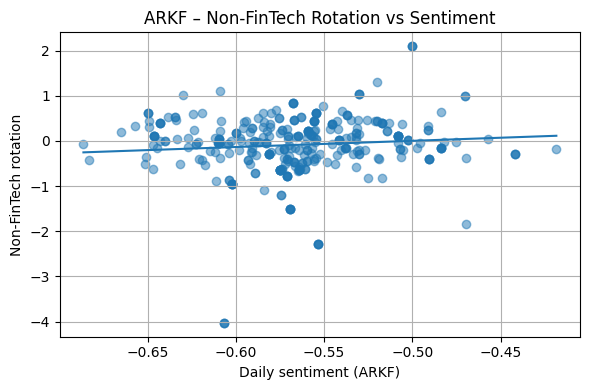

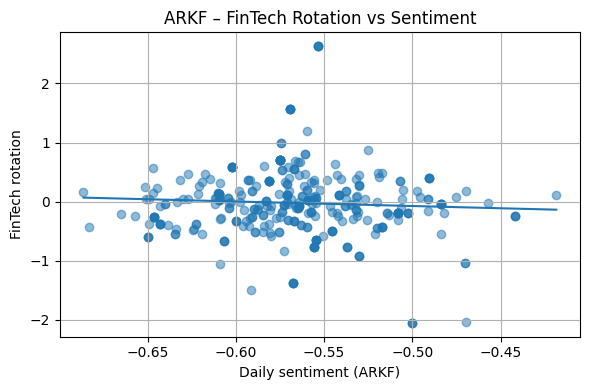

In [ ]:
# ============================================
# Part 2 – Scatter plots with regression lines
# (example: ARKF only; you can copy for ARKK)
# ============================================

# 1) ARKF – Non-FinTech rotation vs sentiment
plt.figure(figsize=(6, 4))

x = arkf_sense["sentiment_arkf"]
y = arkf_sense["rotation_nonfin"]

# Scatter
plt.scatter(x, y, alpha=0.5)

# Regression line (simple linear fit)
beta, alpha = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = beta * x_line + alpha
plt.plot(x_line, y_line)

plt.title("ARKF – Non-FinTech Rotation vs Sentiment")
plt.xlabel("Daily sentiment (ARKF)")
plt.ylabel("Non-FinTech rotation")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) ARKF – FinTech rotation vs sentiment
plt.figure(figsize=(6, 4))

x = arkf_sense["sentiment_arkf"]
y = arkf_sense["rotation_fintech"]

plt.scatter(x, y, alpha=0.5)

beta, alpha = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = beta * x_line + alpha
plt.plot(x_line, y_line)

plt.title("ARKF – FinTech Rotation vs Sentiment")
plt.xlabel("Daily sentiment (ARKF)")
plt.ylabel("FinTech rotation")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# Part 3 – Robustness check with lagged sentiment
# ============================================

import statsmodels.api as sm

# Create lagged sentiment columns
arkk_sense_lag = arkk_sense.copy()
arkf_sense_lag = arkf_sense.copy()

arkk_sense_lag["sentiment_lag1"] = arkk_sense_lag["sentiment_arkk"].shift(1)
arkf_sense_lag["sentiment_lag1"] = arkf_sense_lag["sentiment_arkf"].shift(1)

# Drop rows with NaN (first lag)
arkk_sense_lag = arkk_sense_lag.dropna(subset=["sentiment_lag1"])
arkf_sense_lag = arkf_sense_lag.dropna(subset=["sentiment_lag1"])

def run_ols(df, y_col, x_col):
    X = df[[x_col]]
    y = df[y_col]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model

print("=== ARKK (lagged sentiment) – FinTech rotation ===")
model_ft_arkk_lag = run_ols(arkk_sense_lag, "rotation_fintech", "sentiment_lag1")
print(model_ft_arkk_lag.summary())

print("\n=== ARKK (lagged sentiment) – Non-FinTech rotation ===")
model_nft_arkk_lag = run_ols(arkk_sense_lag, "rotation_nonfin", "sentiment_lag1")
print(model_nft_arkk_lag.summary())

print("\n=== ARKF (lagged sentiment) – FinTech rotation ===")
model_ft_arkf_lag = run_ols(arkf_sense_lag, "rotation_fintech", "sentiment_lag1")
print(model_ft_arkf_lag.summary())

print("\n=== ARKF (lagged sentiment) – Non-FinTech rotation ===")
model_nft_arkf_lag = run_ols(arkf_sense_lag, "rotation_nonfin", "sentiment_lag1")
print(model_nft_arkf_lag.summary())



=== ARKK (lagged sentiment) – FinTech rotation ===
                            OLS Regression Results                            
Dep. Variable:       rotation_fintech   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01331
Date:                Thu, 20 Nov 2025   Prob (F-statistic):              0.908
Time:                        21:02:01   Log-Likelihood:                -527.72
No. Observations:                 774   AIC:                             1059.
Df Residuals:                     772   BIC:                             1069.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

## ARKK

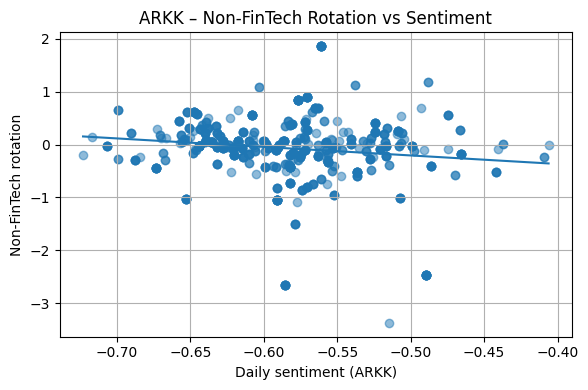

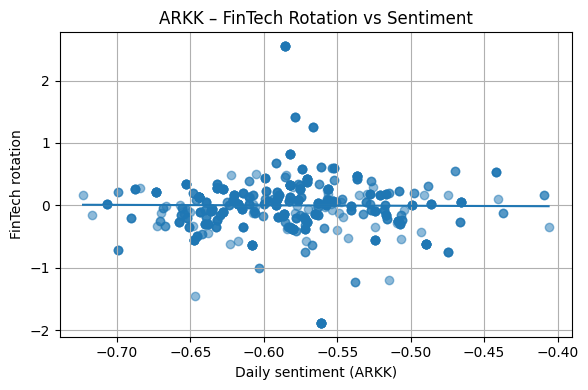

In [ ]:
# ============================================
# ARKK – Non-FinTech rotation vs sentiment
# ============================================

plt.figure(figsize=(6, 4))

x = arkk_sense["sentiment_arkk"]
y = arkk_sense["rotation_nonfin"]

# Scatter plot
plt.scatter(x, y, alpha=0.5)

# Regression line (simple linear fit)
beta, alpha = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = beta * x_line + alpha
plt.plot(x_line, y_line)

plt.title("ARKK – Non-FinTech Rotation vs Sentiment")
plt.xlabel("Daily sentiment (ARKK)")
plt.ylabel("Non-FinTech rotation")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================
# ARKK – FinTech rotation vs sentiment
# ============================================

plt.figure(figsize=(6, 4))

x = arkk_sense["sentiment_arkk"]
y = arkk_sense["rotation_fintech"]

# Scatter plot
plt.scatter(x, y, alpha=0.5)

# Regression line
beta, alpha = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = beta * x_line + alpha
plt.plot(x_line, y_line)

plt.title("ARKK – FinTech Rotation vs Sentiment")
plt.xlabel("Daily sentiment (ARKK)")
plt.ylabel("FinTech rotation")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# ============================================
# Part 3 – Robustness check with lagged sentiment (ARKK only)
# ============================================

import statsmodels.api as sm

# Create lagged sentiment column for ARKK
arkk_sense_lag = arkk_sense.copy()
arkk_sense_lag["sentiment_lag1"] = arkk_sense_lag["sentiment_arkk"].shift(1)

# Drop rows with NaN in lagged sentiment
arkk_sense_lag = arkk_sense_lag.dropna(subset=["sentiment_lag1"])

def run_ols(df, y_col, x_col):
    X = df[[x_col]]
    y = df[y_col]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model

print("=== ARKK (lagged sentiment) – FinTech rotation ===")
model_ft_arkk_lag = run_ols(arkk_sense_lag, "rotation_fintech", "sentiment_lag1")
print(model_ft_arkk_lag.summary())

print("\n=== ARKK (lagged sentiment) – Non-FinTech rotation ===")
model_nft_arkk_lag = run_ols(arkk_sense_lag, "rotation_nonfin", "sentiment_lag1")
print(model_nft_arkk_lag.summary())


=== ARKK (lagged sentiment) – FinTech rotation ===
                            OLS Regression Results                            
Dep. Variable:       rotation_fintech   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01331
Date:                Thu, 20 Nov 2025   Prob (F-statistic):              0.908
Time:                        21:08:50   Log-Likelihood:                -527.72
No. Observations:                 774   AIC:                             1059.
Df Residuals:                     772   BIC:                             1069.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [ ]:
etf_df.to_csv("/content/drive/MyDrive/Fintech/Dataset/Panel_data/etf_df_clean.csv", index=False)
arkk_sense.to_csv("/content/drive/MyDrive/Fintech/Dataset/Panel_data/arkk_sense_clean.csv", index=False)
arkf_sense.to_csv("/content/drive/MyDrive/Fintech/Dataset/Panel_data/arkf_sense_clean.csv", index=False)


* FinTech rotation is basically not affected by news sentiment in either ARKK or ARKF,
  whether we use same-day or lagged sentiment.

* Non-FinTech rotation does react to sentiment:
    * ARKF: same-day sentiment is weakly positively related to non-FinTech rotation.
    * ARKK: lagged sentiment has a significantly negative effect on non-FinTech rotation
      – after positive sentiment days, ARKK tends to cut back its non-FinTech sleeve on the next day.

* Conclusion:
This suggests that FinTech holdings play the role of stable core positions, while non-FinTech holdings function as a flexible satellite sleeve used to implement sentiment-driven adjustments.
